## 모델훈련  

모델을 훈련시킨다는 의미는 모델이 훈련 데이터셋에 가장 잘 맞도록 파라미터를 설정하는 것을 의미한다.  

이번 포스팅에서는 모델을 훈련시킬때 default값 대신, 좋은 하이퍼파라미터를 설정하기 위해 필요한 모델의 작동원리, 알고리즘 등을 공부해 볼 것이다.  

이번 포스팅의 주된 내용은 다음과 같다.  

- 직접 계산할 수 있는 공식을 이용해 파라미터를 해석적으로 구해보기  
- 경사하강법(GD)을 이용한 파라미터 도출  
- 배치(Batch), 미니배치(Mini batch), 확률적(Stochastic) 경사하강법을 이용한 파라미터 도출  
- 비선형 데이터셋을 위한 다항회귀  
- learning curve를 이용한 과대적합 감지 및 규제 기법  

## 1. 선형회귀(linear Regreesion)  

선형회귀는 기본적인 개념이므로 설명은 생략한다.  

선형회귀 모델에 주로 사용되는 비용함수(cost function)는 MSE(Mean Squared Error, 평균제곱오차)이다.  

![png](/assets/images/ML/chap3/mse_func.png){: width="80%" height="80%"}  

위 식은 독립변수가 2개 이상인 다중선형회귀의 일반식이다. 구하는 방식은 단순선형회귀와 같으며, 단지 행렬연산이 들어갈 뿐이다.  
이제 이 비용함수(cost function)를 최소화하기 위한 모수 세타(계수값)를 찾기 위한 방법을 알아보자.  

### 1-1. 정규방정식  

정규방정식은 통계학 시간에 배운적 있는 미분(또는 편미분)을 통해 수학적으로 모수(계수)를 구하는 공식이다.  

![jpg](/assets/images/ML/chap3/normal_equation.jpg){: .align-center}{: width="80%" height="80%"}

어려워 보이지만 회귀식(행렬식) `Y=XB(베타)` 을 미분하여 0이 되게 하는(변곡점) B(베타)를 구한 결과이다.  
유도 과정에는 행렬미분 등 선형대수의 개념들이 필요하다. 자세한 내용은 생략한다.  

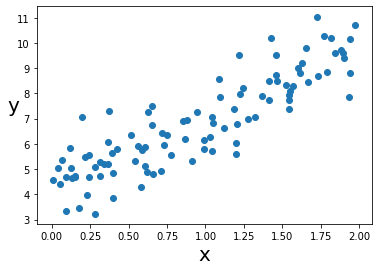

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
X = 2*np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

plt.scatter(X,y)
plt.ylabel("y", fontsize = 20, rotation = 0)
plt.xlabel("x", fontsize = 20)
plt.show()

단순선형회귀를 위해 1차함수 관계에 있는 데이터 셋을 생성했다.  
이를 이용해 수동적으로 정규방정식을 구해보자.  

In [3]:
X_b = np.c_[np.ones((100,1)), X]    # 절편항을 위해 1열에 1값 추가
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)  # 정규방정식

In [4]:
theta_best

array([[4.21509616],
       [2.77011339]])

`np.linalg`은 넘파이의 선형대수 모듈이며 이 모듈 내의 역행렬 함수 `inv()`를 이용해 역행렬을 계산할 수있다.  
또한 `.dot()`은 행렬곱을 위한 연산함수이다.  

우리는 모수인 4(절편)와 3(계수1)을 기대했지만 가우시안 난수(`np.random.randn(100,1)`) 노이즈로 인해 정확하게 재현하지 못했다.  
이제 이 예측 파라미터(theta_best)를 이용해 예측해보자.  

In [52]:
X_new = np.array([[0],[2]])   # 임의의 x값으로 0과 2(범위의 시작과 끝)  
X_new_b = np.c_[np.ones((2,1)), X_new]  # 절편을 위한 1값 추가 ([1,0]과 [1,2])
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

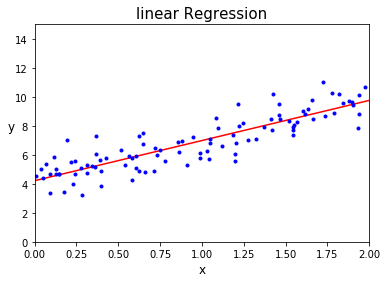

In [66]:
plt.plot(X_new,y_predict, "r-")
plt.plot(X,y, "b.")
# 또는 plt.scatter(X,y)
plt.axis([0,2,0,15])
plt.title("linear Regression", fontsize=15)
plt.ylabel("y", fontsize = 12, rotation = 0)
plt.xlabel("x", fontsize = 12)
plt.show()

이와 같이 수동적으로 수학적 공식을 활용해 선형회귀분석을 수행했다.  
같은 작업을 하는 사이킷런 코드는 다음과 같다.  

In [70]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [75]:
lin_reg.intercept_, lin_reg.coef_ 

(array([4.21509616]), array([[2.77011339]]))

In [81]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

사이킷런에서는 계수값(coef_)과 절편(intercept_)를 분리하여 저장해준다.  

### 1-2. 계산복잡도  

정규방정식은 (n + 1)x(n + 1) 크기가 되는 XT*X의 역행렬을 계산한다.(n은 변수 수)  
역행렬을 계산하는 계산 복잡도(computational complexity)는, n^2.4에서 n^3 사이이다. 따라서 변수가 많아질수록 계산복잡도가 매우 증가해 속도가 느려진다.  
하지만 역행렬 계산 전의 XT*X는 (n x m)*(m x n) 크기의 행렬이므로 샘플 수(m)이 역행렬 계산의 복잡도를 증가시키지 않고 물리적 양만 증가시킨다.(행렬곱에 의해 상쇄)  
